<a href="https://colab.research.google.com/github/TheodorIvanov/Summer_Project/blob/master/summer_project_combined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading the data

In [1]:
from google.colab import files # insert json token

import json # alternatively can use files.upload()
dict = {"username":"tedbg41","key":"e8b997c78473e26b4bec20ca33c9ca66"}
with open('kaggle.json', 'w') as fp:
    json.dump(dict, fp)

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

# Downloading the Zip database from Kaggle

!kaggle datasets download -d mlg-ulb/creditcardfraud

# Unzipping the file

import zipfile
with zipfile.ZipFile("creditcardfraud.zip","r") as zip_ref:
    zip_ref.extractall()

creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)


## Libraries and Settings


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


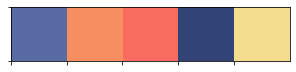

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
import seaborn as sns
#sns.set_palette("Set2")
palette = ['#586ba4','#f68e5f','#f76c5e','#324376','#f5dd90']
sns.set_palette(palette) # https://coolors.co/palettes/trending
cont = sns.diverging_palette(25, 255, s=70, sep=1, l=50, as_cmap=True, center='light')
sns.palplot(sns.color_palette())
sns.set_style("darkgrid")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
import keras
from keras.layers import *
from keras import losses
from keras import optimizers
from keras import regularizers
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

# Supressing  Warnings

import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

# Random state seed

seed = 66


## Custom Functions

In [3]:
# SVM section Functions

def Model_Performance(model, X_test, y_test, prediction):

  '''
  Creates a report including the confusion matrix and the ROC curve for the model provided.

  model: object, the model under evaluation
  X_test: pd.DataFrame, the test data
  y_test: pd.DataFrame, the test target labels
  predictions: pd.Dataframe, the predicted labels
  
  '''

  # Performance Metrics
  print('\n Confusion Matrix \n =================================== \n')
  sns.heatmap(confusion_matrix(y_test,prediction), annot = True, cmap=cont, fmt='g', cbar=False)
  plt.title('Confusion Matrix')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.show()
  print('\n Classification Report \n =================================== \n', classification_report(y_test,prediction))

  # Reciever Receiver operating characteristic (ROC) curve
  if model:
    from sklearn.metrics import plot_roc_curve
    svc_disp = plot_roc_curve(model, X_test, y_test)
    plt.title('ROC Graph')
    plt.show()
  else:
    pass

def SVM_search(X_train, X_test, y_train, y_test, grid_search=True, verbose=0, jobs=1, evaluate=False):
  from sklearn.model_selection import GridSearchCV

  # Supressing the flood of Data Conversion Warnings
  import warnings
  from sklearn.exceptions import DataConversionWarning
  warnings.filterwarnings(action='ignore', category=DataConversionWarning)
  
  if grid_search: # if grid_search parameter is True then

    # SVM Classifiers
    kernels = ['Polynomial', 'RBF', 'Sigmoid','Linear']

    #A function which returns the corresponding SVC model
    def getClassifier(ktype):
        if ktype == 0:
            # Polynomial kernal
            return SVC(kernel='poly', degree=8, gamma="auto")
        elif ktype == 1:
            # Radial Basis Function kernal
            return SVC(kernel='rbf', gamma="auto")
        elif ktype == 2:
            # Sigmoid kernal
            return SVC(kernel='sigmoid', gamma="auto")
        elif ktype == 3:
            # Linear kernal
            return SVC(kernel='linear', gamma="auto")

    for i in range(4):
      # Train a SVC model using different kernal
      svclassifier = getClassifier(i) 
      svclassifier.fit(X_train, y_train)
      # Make prediction
      y_pred = svclassifier.predict(X_test)
      # Evaluate our model
      if evaluate:
        print("Evaluation:", kernels[i], "kernel")  # Can be uncommented for further details
        print(classification_report(y_test,y_pred))
      else:
        pass

    # Setting the Search Parameters
    param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
    
    # Performing the Grid Search
    grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=verbose, n_jobs=jobs)
    model = grid.fit(X_train,y_train)

    # Performance Metrics
    
    print('\n Best Estimator Model \n =================================== \n', grid.best_estimator_)
    grid_predictions = grid.predict(X_test)
    Model_Performance(model = model, X_test = X_test, y_test = y_test, prediction = grid_predictions)

  else:
    # Performing the Standard Model
    model = svm.SVC().fit(X_train, y_train)
    prediction = model.predict(X_test)

    # Performance Metrics
    Model_Performance(model = model, X_test = X_test, y_test=y_test, prediction=prediction)

# Autoencoder section Functions

def LossGraph(history):
  plt.figure(figsize = (12,9))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')
  plt.show();

def ReconstructionScatter(cleared, frauds, threshold): 
  plt.figure(figsize = (12,9))
  plt.scatter(cleared.index, cleared.values, marker = 'o', label = 'Cleared')
  plt.scatter(frauds.index, frauds.values, marker = 'x', label = 'Fraud')
  plt.hlines(threshold, plt.xlim()[0], plt.xlim()[1], colors = 'r', label = 'Threshold')
  plt.legend(loc = 'best')
  plt.title('Reconstructed Transactions')
  plt.xlabel('Transaction ID')
  plt.ylabel('Root Reconstruction Error')
  plt.show();

def ModelPerformance(X_test, y_test, prediction):
  print('\n Confusion Matrix \n =================================== \n')
  sns.heatmap(confusion_matrix(y_test,prediction), annot = True, cmap='RdBu', fmt='g', cbar=False)
  plt.title('Confusion Matrix')
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.show();
  print('\n Classification Report \n =================================== \n', classification_report(y_test,prediction))


## Exploratory Analysis

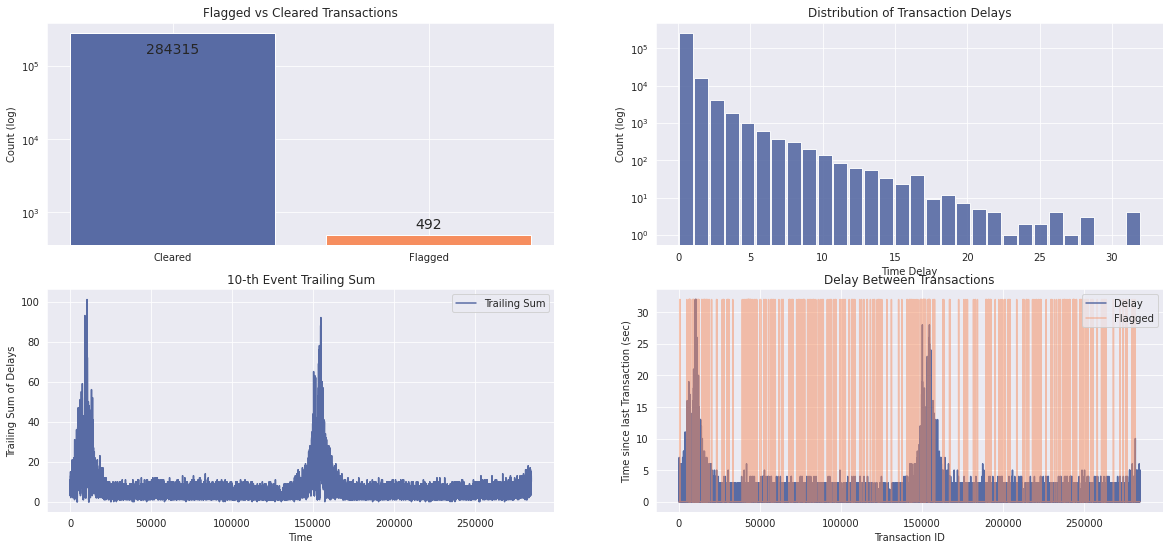

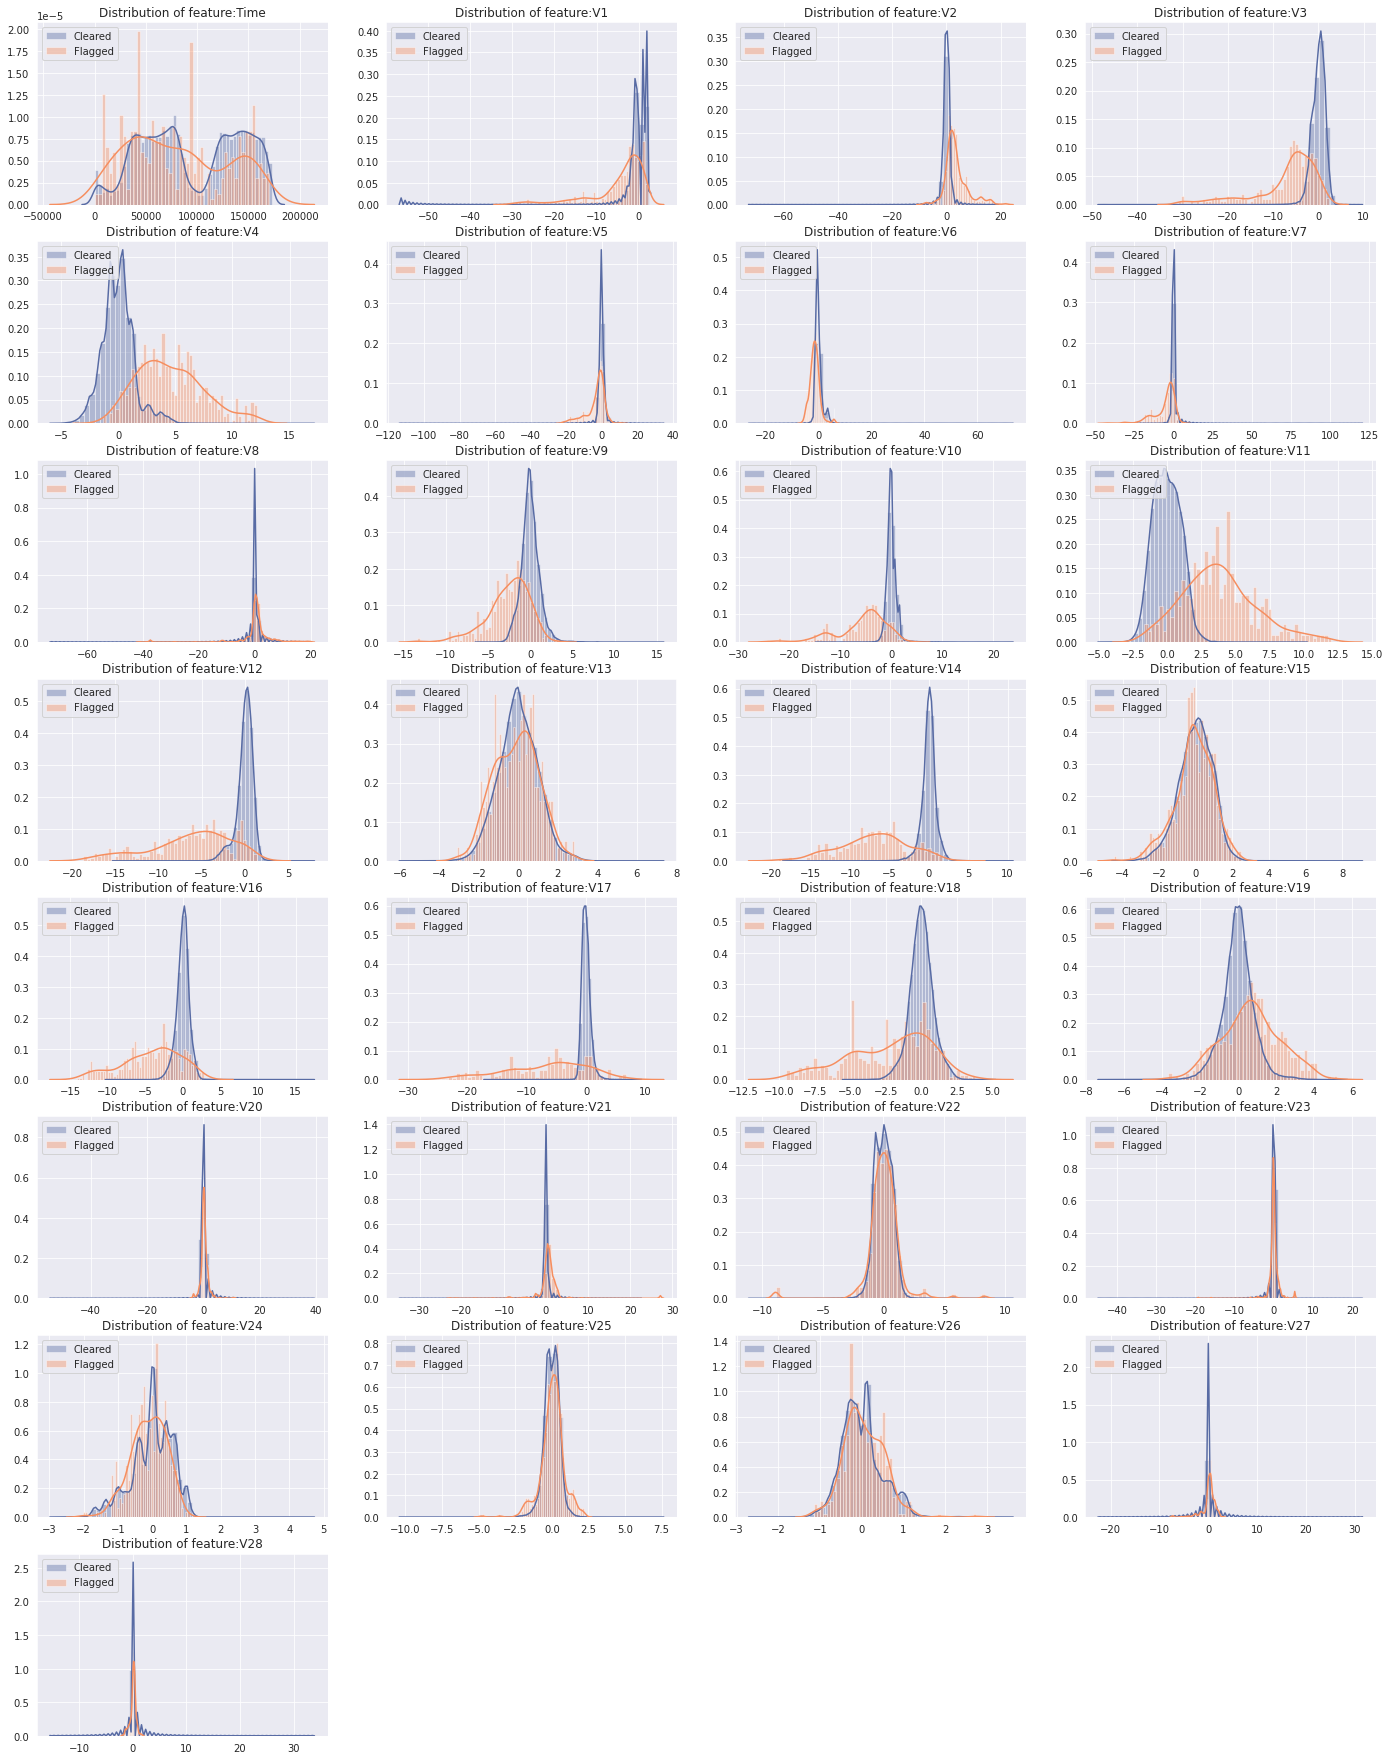

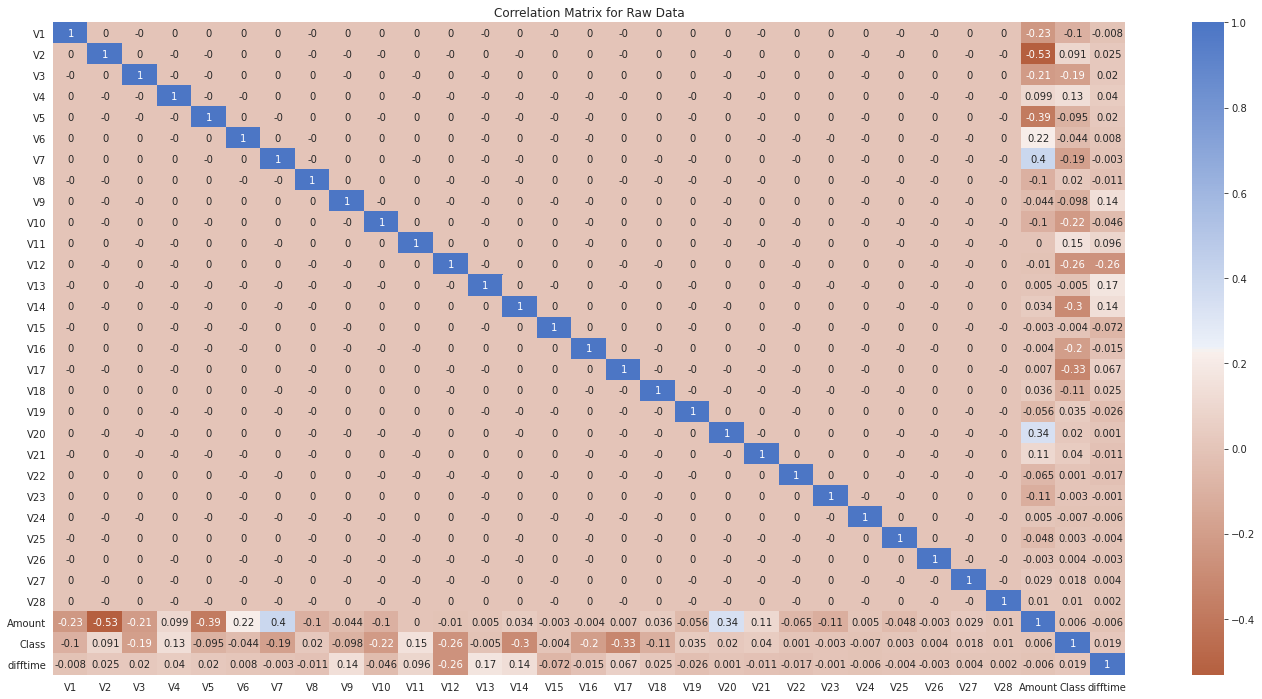

In [4]:
df = pd.read_csv('creditcard.csv')

# Descriptives and checking for NaNs

# print('\n Shape \n =================================== \n',  df.shape)
# print('\n Data types \n =================================== \n', df.dtypes)
# print('\n Checking for NANs \n =================================== \n', df.isnull().sum())

# Differencing with Lag = 1 to measure the time intervals between each transaction

df['difftime'] = np.insert(np.diff(df['Time'], n=1),0,0) 

# Plotting the time intervals and flagged transactions

plt.figure(figsize=(20,9))
plt.subplot(221)
plt.bar(x=df['Class'].value_counts().index,
        height=df['Class'].value_counts().values, alpha = 1,
        color=sns.color_palette(),log=True)
plt.text(0,150000, str(df['Class'].value_counts().values[0]),
         fontsize = 14, horizontalalignment='center')
plt.text(1,600, str(df['Class'].value_counts().values[1]),
         fontsize = 14, horizontalalignment='center')
plt.title('Flagged vs Cleared Transactions')
plt.ylabel('Count (log)')
plt.grid(True)
plt.xticks([0,1],['Cleared', 'Flagged'])

plt.subplot(222)
plt.hist(df['difftime'], bins=30, log=True, rwidth=0.9, alpha=0.9)
plt.title('Distribution of Transaction Delays')
plt.xlabel('Time Delay')
plt.ylabel('Count (log)')
plt.grid(True)

plt.subplot(223)
plt.plot(df['difftime'].rolling(10).sum(), label = 'Trailing Sum')
plt.title('10-th Event Trailing Sum')
plt.legend(loc=1)
plt.xlabel('Time')
plt.ylabel('Trailing Sum of Delays')
plt.grid(True)

plt.subplot(224)
plt.plot(df['difftime'],alpha=1, label = 'Delay')
plt.plot(df['Class']*32, alpha=0.5, label = 'Flagged') # multiply by 32 to fill the yaxis
plt.legend(loc=1)
plt.grid(True)
plt.xlabel('Transaction ID')
plt.ylabel('Time since last Transaction (sec)')
plt.title('Delay Between Transactions')
plt.axis('tight')

plt.show()

# Plotting the distributions of the features by class

features = df.iloc[:,0:29].columns
plt.figure(figsize=(24,28*4))
gs = gridspec.GridSpec(28, 4)

for i, c in enumerate(df[features]):
 ax = plt.subplot(gs[i])
 sns.distplot(df[c][df.Class == 0], bins=50, label='Cleared')
 sns.distplot(df[c][df.Class == 1], bins=50, label='Flagged')
 ax.set_xlabel('')
 ax.set_title('Distribution of feature:' + str(c))
 plt.legend(loc=2)

plt.show()

#Plotting the correlation matrix

plt.figure(figsize=(24,12))
sns.heatmap(round(df.loc[:, df.columns != 'Time'].corr(), 3),
            cmap = cont,
            annot=True)
plt.title('Correlation Matrix for Raw Data')
plt.show()

# Scaling the data

scaled = pd.DataFrame(StandardScaler().fit_transform(df.drop(['Time','Class'], axis=1)),
                      columns=df.drop(['Time','Class'], axis=1).columns) # scaling all columns apart from Time and Class
scaled['Class'] = df['Class']


# Feature Selection

In [5]:
# Using Random Forest Classifier

forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=seed)

y = scaled['Class']
X = scaled.drop(['Class'],axis=1)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


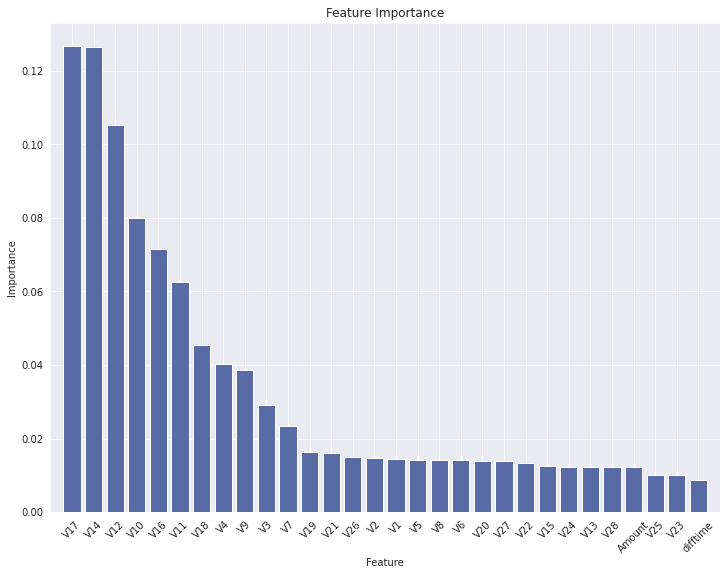

In [6]:

# Print the feature ranking

ordered_features = pd.DataFrame((X.iloc[:, indices].columns.values,importances[indices])).T
ordered_features.columns = ['feature','importance']


# Plot the impurity-based feature importances of the forest

plt.figure(figsize=(12,9))
plt.title("Feature Importance")
plt.bar(X.iloc[:, indices].columns.values, importances[indices],
        color = palette[0],
       #yerr=std[indices],
        align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.xticks(np.arange(X.shape[1]), (X.iloc[:, indices].columns.values),rotation=45)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()


## SVM Models


 Best Estimator Model 
 SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

 Confusion Matrix 



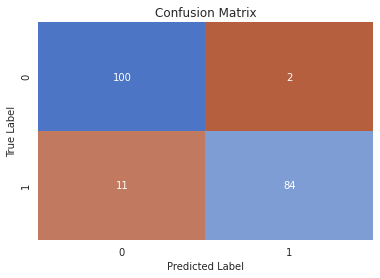


 Classification Report 
               precision    recall  f1-score   support

           0       0.90      0.98      0.94       102
           1       0.98      0.88      0.93        95

    accuracy                           0.93       197
   macro avg       0.94      0.93      0.93       197
weighted avg       0.94      0.93      0.93       197



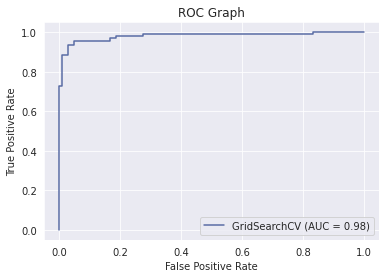


 Confusion Matrix 



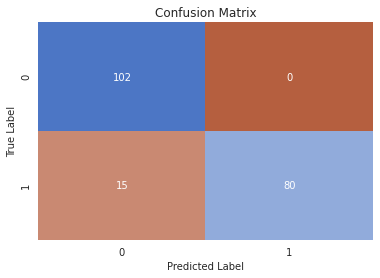


 Classification Report 
               precision    recall  f1-score   support

           0       0.87      1.00      0.93       102
           1       1.00      0.84      0.91        95

    accuracy                           0.92       197
   macro avg       0.94      0.92      0.92       197
weighted avg       0.93      0.92      0.92       197



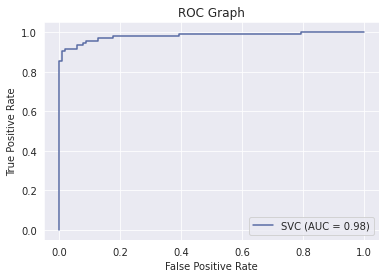


 Confusion Matrix 



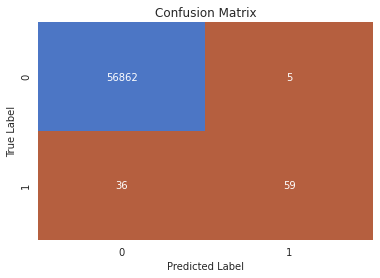


 Classification Report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56867
           1       0.92      0.62      0.74        95

    accuracy                           1.00     56962
   macro avg       0.96      0.81      0.87     56962
weighted avg       1.00      1.00      1.00     56962



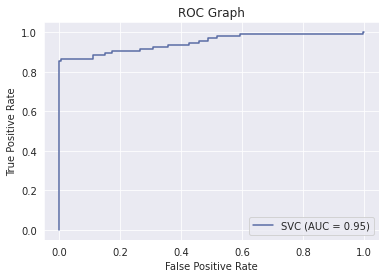


 Confusion Matrix 



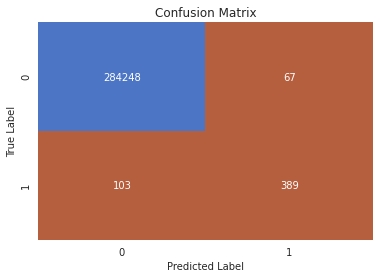


 Classification Report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.85      0.79      0.82       492

    accuracy                           1.00    284807
   macro avg       0.93      0.90      0.91    284807
weighted avg       1.00      1.00      1.00    284807


 Confusion Matrix 



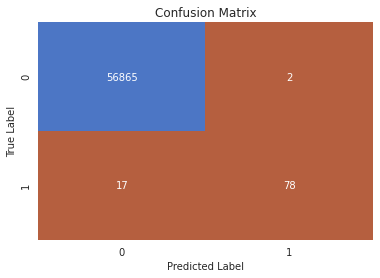


 Classification Report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56867
           1       0.97      0.82      0.89        95

    accuracy                           1.00     56962
   macro avg       0.99      0.91      0.95     56962
weighted avg       1.00      1.00      1.00     56962



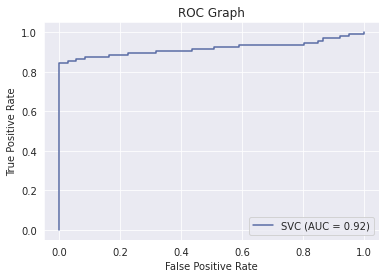

In [7]:

# Undersampling to account for the uneven balance between Flagged and Cleared transactions

frauds = scaled[scaled.Class == 1]
cleared = scaled[scaled.Class == 0]

cleared_sample = cleared.loc[np.random.choice(cleared.index, size = len(frauds)),:] # selects a random set of cleared transactions equal to the number of frauds 

undersample = [frauds, cleared_sample]
undersample = pd.concat(undersample)

# Splitting into training and validation sets

X = undersample.loc[:, undersample.columns != 'Class']
y = undersample.loc[:, undersample.columns == 'Class']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = seed)

# SVM for Undersampled data

SVM_search(X_train, X_test, y_train, y_test,grid_search=True, jobs =-1)
SVM_search(X_train, X_test, y_train, y_test,grid_search=False)

# SVM for Normal Data

X = scaled.loc[:, scaled.columns != 'Class']
y = scaled.loc[:, scaled.columns == 'Class']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = seed)

SVM_search(X_train, X_test, y_train, y_test, grid_search=False, jobs=-1, verbose=2)

# Manual Model for the Full Scaled data using the Best of the Undersampled models

X = undersample.loc[:, undersample.columns != 'Class']
y = undersample.loc[:, undersample.columns == 'Class']

X_train, _ , y_train, _  = train_test_split(X,y, train_size = 0.8, random_state = seed)

model = svm.SVC(C=0.01, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma=0.01, kernel='poly',
    max_iter=-1, probability=False, random_state=66, shrinking=True,
    tol=0.001, verbose=False).fit(X_train, y_train)

X = scaled.loc[:, scaled.columns != 'Class']
y = scaled.loc[:, scaled.columns == 'Class']

prediction = model.predict(X)

# Model using Selected features

# Performance Metrics
Model_Performance(False, False, y, prediction)

fs = scaled.iloc[:, [2, 3, 8, 9, 10, 11, 13, 15, 16, 17, -1]] # selecting the features which show different distributions between cleared and flagged transactions
#fs = scaled[['V17','V14','V12','V10', 'V16', 'V11', 'Class']]

X = fs.loc[:, fs.columns != 'Class']
y = fs.loc[:, fs.columns == 'Class']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, random_state = seed)

model = svm.SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=66, shrinking=True,
    tol=0.001, verbose=False).fit(X_train, y_train)

prediction = model.predict(X_test)

# Performance Metrics
Model_Performance(model, X_test, y_test, prediction)


## Autoencoder Models

Train on 227448 samples, validate on 56962 samples
Epoch 1/100
 - 3s - loss: 0.6951 - mae: 0.5360 - accuracy: 0.5000 - val_loss: 0.6795 - val_mae: 0.4940 - val_accuracy: 0.6320
Epoch 2/100
 - 3s - loss: 0.6129 - mae: 0.4692 - accuracy: 0.6766 - val_loss: 0.6511 - val_mae: 0.4596 - val_accuracy: 0.7078
Epoch 3/100
 - 3s - loss: 0.5939 - mae: 0.4449 - accuracy: 0.7213 - val_loss: 0.6406 - val_mae: 0.4503 - val_accuracy: 0.7163
Epoch 4/100
 - 3s - loss: 0.5792 - mae: 0.4292 - accuracy: 0.7506 - val_loss: 0.6236 - val_mae: 0.4284 - val_accuracy: 0.7642
Epoch 5/100
 - 3s - loss: 0.5733 - mae: 0.4213 - accuracy: 0.7663 - val_loss: 0.6209 - val_mae: 0.4224 - val_accuracy: 0.7744
Epoch 6/100
 - 3s - loss: 0.5704 - mae: 0.4157 - accuracy: 0.7745 - val_loss: 0.6175 - val_mae: 0.4166 - val_accuracy: 0.7847
Epoch 7/100
 - 3s - loss: 0.5692 - mae: 0.4130 - accuracy: 0.7779 - val_loss: 0.6175 - val_mae: 0.4167 - val_accuracy: 0.7826
Epoch 8/100
 - 3s - loss: 0.5679 - mae: 0.4099 - accuracy: 0.7825 -

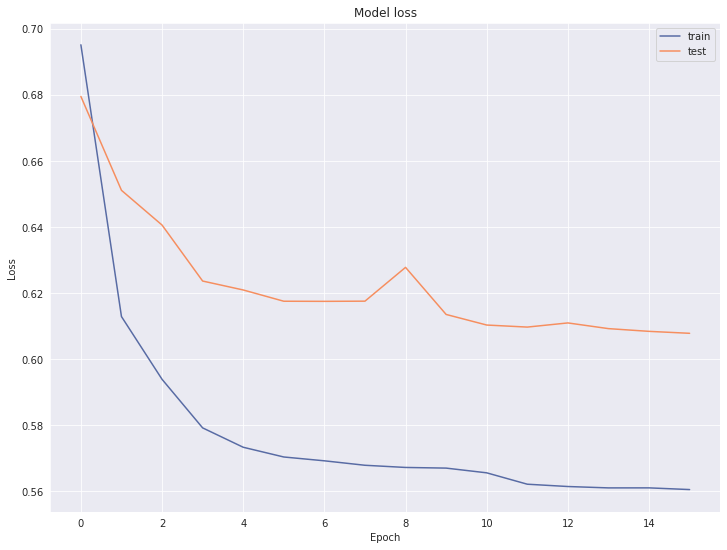

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


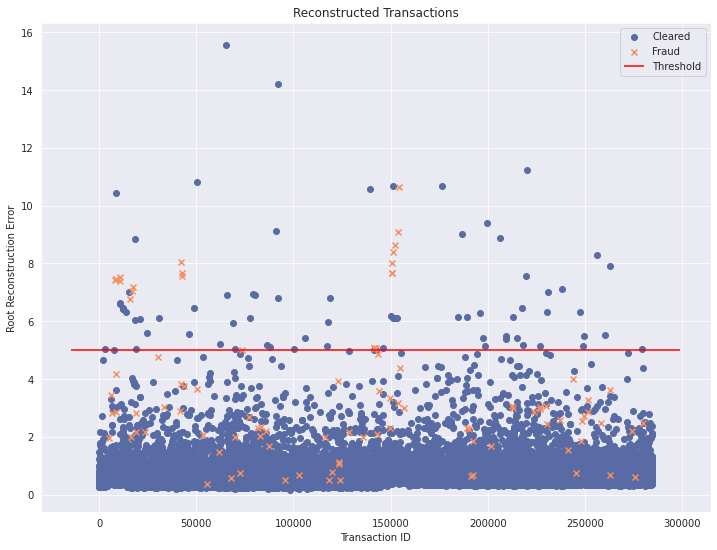


 Confusion Matrix 



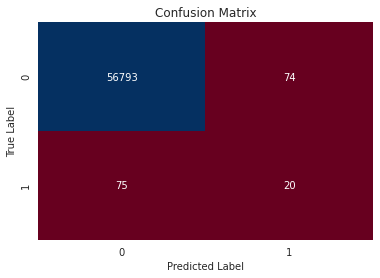


 Classification Report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56867
           1       0.21      0.21      0.21        95

    accuracy                           1.00     56962
   macro avg       0.61      0.60      0.61     56962
weighted avg       1.00      1.00      1.00     56962



In [8]:
# Splitting the data

train, test = train_test_split(scaled, test_size = 0.2, random_state = seed)

X_train = (train[train.Class == 0]).drop(['Class'], axis = 1) # using only the cleared transactions for training
X_test = test.drop(['Class'], axis=1)
y_test = test['Class']

input_dim = X_train.shape[1] # input dimensions for the neural networks

layer1 = X_train.shape[1]
layer2 = (layer1-2)
latent = (layer2-2)

#latent = 9 # dimension of the latent vector

batch_size = 128
epochs = 100

# Defining the Model

inputs = Input(shape=(input_dim,), name = 'input_encoder')

encoder = Dense(layer1, activation='relu')(inputs) #18
encoder = Dense(layer2, activation='relu')(encoder) #12

bottleneck  = Dense(latent, activation='relu')(encoder)

decoder = Dense(layer2, activation='relu')(bottleneck)
decoder = Dense(layer1, activation='relu')(decoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder_1 = Model(inputs,decoder)
# autoencoder_1.summary()
# keras.utils.plot_model(autoencoder_1, show_shapes=True)

# Compiling the model

autoencoder_1.compile(optimizer=keras.optimizers.Adam(),
                      loss = losses.mean_squared_error,
                      metrics = ['mae','accuracy'])

# Early Stopper

stopper = EarlyStopping(monitor = 'val_loss',
                        min_delta = 0.005,
                        verbose = 1,
                        patience = 5,
                        restore_best_weights = True)

# Training

history = autoencoder_1.fit(X_train, X_train,
                            batch_size = batch_size,
                            epochs = epochs,
                            verbose = 2,
                            validation_data = (X_test, X_test),
                            callbacks = [stopper])

LossGraph(history)

# Predicting

predictions = autoencoder_1.predict(X_test)

# Reconstruction error (RMSE)

rmse = np.sqrt(np.mean(np.power(X_test - predictions, 2), axis = 1))

# Reconstructed data

reconstructed = pd.DataFrame({'rec_error': rmse,'true_class': y_test})

frauds = reconstructed[reconstructed.true_class == 1].drop('true_class', axis = 1)
cleared = reconstructed[reconstructed.true_class == 0].drop('true_class', axis = 1)

# Predicting the class using the threshtold

threshold = 5

reconstructed['pred_class'] = 0
reconstructed.pred_class[reconstructed.rec_error > threshold] = 1

# Model Performance

ReconstructionScatter(cleared, frauds, threshold = threshold)
ModelPerformance(X_test, y_test, reconstructed.pred_class)



Train on 227448 samples, validate on 56962 samples
Epoch 1/100
 - 3s - loss: 0.7944 - mae: 0.5883 - accuracy: 0.4808 - val_loss: 0.6945 - val_mae: 0.5025 - val_accuracy: 0.7201
Epoch 2/100
 - 3s - loss: 0.5348 - mae: 0.4490 - accuracy: 0.8558 - val_loss: 0.6104 - val_mae: 0.4334 - val_accuracy: 0.9107
Epoch 3/100
 - 2s - loss: 0.4945 - mae: 0.4137 - accuracy: 0.9210 - val_loss: 0.5910 - val_mae: 0.4183 - val_accuracy: 0.9193
Epoch 4/100
 - 3s - loss: 0.4738 - mae: 0.3943 - accuracy: 0.9339 - val_loss: 0.5694 - val_mae: 0.3975 - val_accuracy: 0.9322
Epoch 5/100
 - 3s - loss: 0.4641 - mae: 0.3847 - accuracy: 0.9400 - val_loss: 0.5622 - val_mae: 0.3912 - val_accuracy: 0.9410
Epoch 6/100
 - 2s - loss: 0.4603 - mae: 0.3823 - accuracy: 0.9412 - val_loss: 0.5592 - val_mae: 0.3892 - val_accuracy: 0.9386
Epoch 7/100
 - 3s - loss: 0.4580 - mae: 0.3813 - accuracy: 0.9408 - val_loss: 0.5572 - val_mae: 0.3883 - val_accuracy: 0.9456
Epoch 8/100
 - 3s - loss: 0.4563 - mae: 0.3793 - accuracy: 0.9421 -

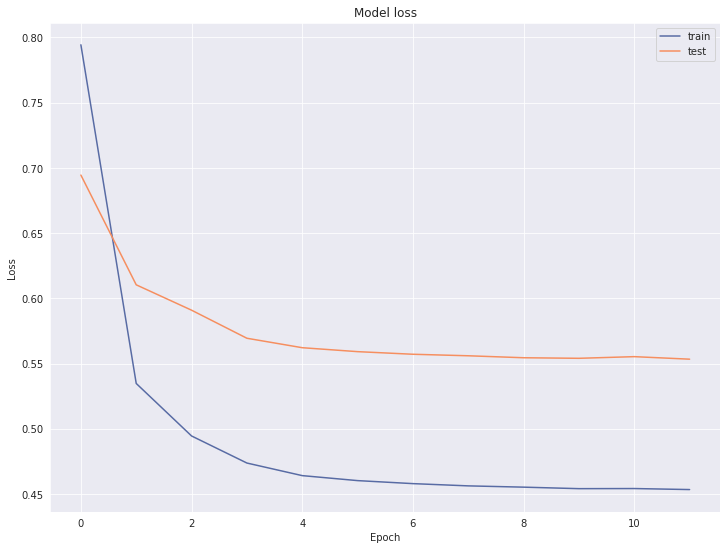

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


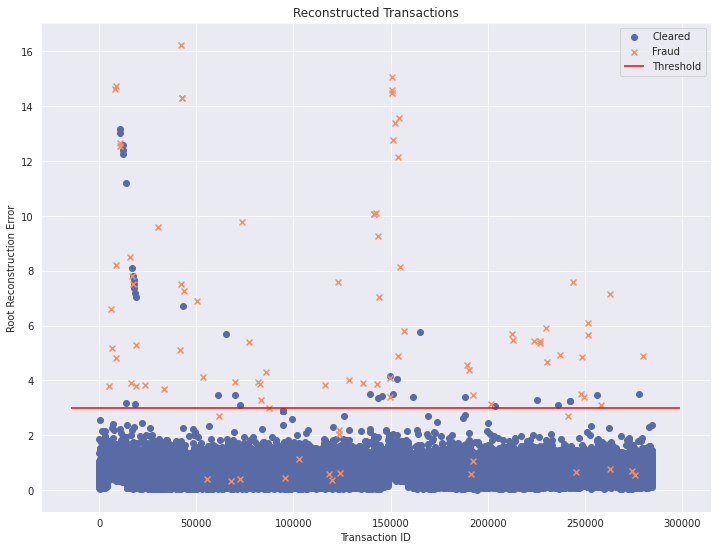


 Confusion Matrix 



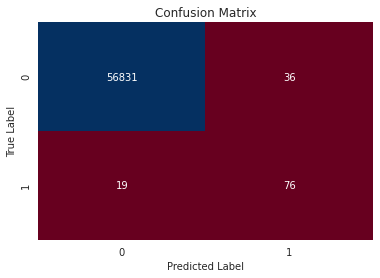


 Classification Report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56867
           1       0.68      0.80      0.73        95

    accuracy                           1.00     56962
   macro avg       0.84      0.90      0.87     56962
weighted avg       1.00      1.00      1.00     56962



In [9]:
# Feature Selection

#scaled = scaled.iloc[:, [2, 3, 8, 9, 10, 11, 13, 15, 16, 17, -1]]
scaled = scaled[['V17','V14','V12','V10', 'V16', 'V11', 'Class']]

# Splitting the data

train, test = train_test_split(scaled, test_size = 0.2, random_state = seed)

X_train = (train[train.Class == 0]).drop(['Class'], axis = 1) # using only the cleared transactions for training
X_test = test.drop(['Class'], axis=1)
y_test = test['Class']

input_dim = X_train.shape[1] # input dimensions for the neural networks

latent = 5 # dimension of the latent vector 5 
batch_size = 128 # 128
epochs = 100
reg = 0.001 # regularisation parameter

# Defining the Model

inputs = Input(shape=(input_dim,), name = 'input_encoder')

encoder = Dense(15, activation='relu', activity_regularizer = regularizers.l2(reg))(inputs) # 6
#encoder = Dense(20, activation='relu', activity_regularizer = regularizers.l2(reg))(encoder) # 9

bottleneck  = Dense(latent, activation='relu', activity_regularizer = regularizers.l2(reg))(encoder)

decoder = Dense(15, activation='relu', activity_regularizer = regularizers.l2(reg))(bottleneck)
#decoder = Dense(15, activation='relu', activity_regularizer = regularizers.l2(reg))(decoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder_2 = Model(inputs,decoder)
# autoencoder_2.summary()
# keras.utils.plot_model(autoencoder_2, show_shapes=True)

# Compiling the model

autoencoder_2.compile(optimizer=keras.optimizers.Adam(),
                      loss = losses.mean_squared_error, # mse
                      metrics = ['mae','accuracy'])

# Early Stopper

stopper = EarlyStopping(monitor = 'val_loss',
                        min_delta = 0.005,
                        verbose = 1,
                        patience = 5,
                        restore_best_weights = True)

# Training

history = autoencoder_2.fit(X_train, X_train,
                            batch_size = batch_size,
                            epochs = epochs,
                            verbose = 2,
                            validation_data = (X_test, X_test),
                            callbacks = [stopper])

LossGraph(history)

# Predicting

predictions = autoencoder_2.predict(X_test)

# Reconstruction error (RMSE)

rmse = np.sqrt(np.mean(np.power(X_test - predictions, 2), axis = 1))

# Reconstructed data

reconstructed = pd.DataFrame({'rec_error': rmse,'true_class': y_test})

frauds = reconstructed[reconstructed.true_class == 1].drop('true_class', axis = 1)
cleared = reconstructed[reconstructed.true_class == 0].drop('true_class', axis = 1)

# Predicting the class using the threshtold

threshold = 3

reconstructed['pred_class'] = 0
reconstructed.pred_class[reconstructed.rec_error > threshold] = 1

# Model Performance

ReconstructionScatter(cleared, frauds, threshold = threshold)
ModelPerformance(X_test, y_test, reconstructed.pred_class)